In [73]:
import datetime
import json
import os
import random
import sys
import warnings
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../../common'))
from ppg_feature_processor import generate_train_feature

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*Conversion of an array with ndim > 0 to a scalar is deprecated.*")

In [49]:
## 1)Read the university subjects and find the positive and negative subjects.

In [50]:
# 读取 Excel 文件
middleSchool_userProfile_file = r'./outdir/MiddleSchool_Depression_Anxiety.xlsx'
university_userProfile_file = '../../../Data/healthy_scale_results.xlsx'  # 将此替换为您的 Excel 文件路径
hospital_userProfile_file = '../../../Data/unhealthy_clinic_results.xlsx'

In [51]:
### READ THE HOSPITAL SUBJECTS
df_hospital = pd.read_excel(hospital_userProfile_file)
print(df_hospital.columns)

hospital_positive_subjects_df = df_hospital[(df_hospital['抑郁'] == 1) & (df_hospital['年龄'] <= 40)][['床号', '性别', '年龄', '抑郁']]
print(hospital_positive_subjects_df)


hospital_positive_subjects = hospital_positive_subjects_df['床号'].tolist()
print("\nHospital Positive Depression subjects: ", hospital_positive_subjects)

Index(['床号', '性别', '年龄', '入院时间', '入院诊断', '病情备注', '抑郁', '焦虑', '双向情感障碍', '睡眠障碍'], dtype='object')
               床号 性别  年龄  抑郁
0   20240619_2A02  女  25   1
11  20240619_2A22  男  38   1
13  20240619_2A27  女  39   1
17  20240619_2A50  女  13   1
18  20240626_2A13  女  37   1
20  20240626_2A50  男  36   1
28  20240710_2A05  女  36   1
30  20240710_2A09  女  37   1
33  20240710_2A16  女  33   1
34  20240710_2A23  女  38   1
37  20240710_2A31  女  40   1
45  20240717_2A12  女  15   1
49  20240717_2A21  女  14   1
51  20240717_2A51  女  16   1

Hospital Positive Depression subjects:  ['20240619_2A02', '20240619_2A22', '20240619_2A27', '20240619_2A50', '20240626_2A13', '20240626_2A50', '20240710_2A05', '20240710_2A09', '20240710_2A16', '20240710_2A23', '20240710_2A31', '20240717_2A12', '20240717_2A21', '20240717_2A51']


In [52]:
### READ THE UNIVERSITY SUBJECTS
df_university = pd.read_excel(university_userProfile_file, sheet_name='SDS')

valid_cols = df_university.columns.values[3::]

df_university['score'] = df_university[valid_cols].sum(axis=1) / 80 * 100

university_positive_subjects_SDS = df_university[df_university['score'] >= 60]['ID'].tolist()
print("University Positive Depression subjects: ", university_positive_subjects_SDS)

university_negative_subjects_SDS = df_university[df_university['score'] < 60]['ID'].tolist()
print("University Negative Depression subjects: ", university_negative_subjects_SDS)

University Positive Depression subjects:  ['A04', 'A07', 'A09', 'A11', 'A15', 'A21', 'A25', 'A27', 'A29', 'A32', 'A33', 'A39', 'A48', 'A52']
University Negative Depression subjects:  ['A01', 'A02', 'A03', 'A05', 'A06', 'A08', 'A10', 'A12', 'A13', 'A14', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24', 'A26', 'A28', 'A30', 'A34', 'A35', 'A36', 'A37', 'A38', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A49', 'A50', 'A51', 'A53', 'A54', 'A55']


In [53]:
### READ THE MIDDLESCHOOL SUBJECTS
df_middle = pd.read_excel(middleSchool_userProfile_file)
df_middle = df_middle[df_middle['depression_label'] != -1]
print(f"Midlle schold available subject count: {df_middle.shape}")


middle_pos_subjects = df_middle[df_middle['depression_label']==1]['user_id'].values.tolist()
middle_neg_subjects = df_middle[df_middle['depression_label']==0]['user_id'].values.tolist()

print(f"middle anxiety positive subjects count: {len(middle_pos_subjects)}")
print(f"middle anxiety negative subjects count: {len(middle_neg_subjects)}")

Midlle schold available subject count: (290, 108)
middle anxiety positive subjects count: 62
middle anxiety negative subjects count: 228


In [54]:
profile_dict = dict()

for _, row in df_hospital.iterrows():
    userId = row['床号']
    gender = 'Male' if row['性别'] == '男' else 'Female'
    age = row['年龄']
    profile_dict[userId] = (gender, age)

for _, row in df_university.iterrows():
    userId = row['ID']
    gender = 'Male' if row['Sex'] == '男' else 'Female'
    age = row['Age (years)']
    profile_dict[userId] = (gender, age)

for _, row in df_middle.iterrows():
    userId = row['user_id']
    gender = row['gender']
    age = 13
    profile_dict[userId] = (gender, age)

# for key, val in profile_dict.items():
#     print(f"userId: {key}, value: {val}")


In [55]:
random.shuffle(middle_pos_subjects)
random.shuffle(middle_neg_subjects)

test_subject_count = 15

test_pos_subjects = middle_pos_subjects[0:test_subject_count]
test_neg_subjects = middle_neg_subjects[0:test_subject_count]

train_pos_subjects = middle_pos_subjects[test_subject_count::] + university_positive_subjects_SDS + hospital_positive_subjects
train_neg_subjects = middle_neg_subjects[test_subject_count::] + university_negative_subjects_SDS

print(f"train postive subjects: {len(train_pos_subjects)}")
print(f"train negative subjects: {len(train_neg_subjects)}")

print(f"test postive subjects: {len(test_pos_subjects)}")
print(f"test negative subjects: {len(test_neg_subjects)}")


train postive subjects: 75
train negative subjects: 253
test postive subjects: 15
test negative subjects: 15


In [56]:
def load_wave_university_or_hospital(path):
    with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['MesureData']['Datas']
            final = [i for i in list_data]
            return final

def load_wave_middleSchool(path):
    try:
        with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['RawResults'][0]['rawDatas']
            final = [i/100000 for i in list_data]
        return final
    except (KeyError, IndexError, TypeError):
        with open(path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data["datas"]


In [57]:
sample_freq = 125
sample_window_minute = 0.5

university_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\healthy'
middle_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data'
hospital_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\unhealthy'

In [58]:
def generate_dataset(subject_collection, label, data_aug_times=1):
    ignored_id = []
    dataset = pd.DataFrame()
    for subject in subject_collection:
            subject_wave = []

            # The university subjects.
            if subject in (university_positive_subjects_SDS + university_negative_subjects_SDS):
                files = os.listdir(university_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(university_file_dir, file)
                        print(f"university file path: {file_path}")
                        tmp_wave = load_wave_university_or_hospital(file_path)
                        subject_wave += tmp_wave
            
            # The hospital subjects.
            elif subject in hospital_positive_subjects:
                files = os.listdir(hospital_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(hospital_file_dir, file)
                        print(f"hospital file path: {file_path}")
                        tmp_wave = load_wave_university_or_hospital(file_path)
                        subject_wave += tmp_wave
            
            # The middle school subjects.
            elif subject in (middle_pos_subjects + middle_neg_subjects):
                files = os.listdir(middle_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(middle_file_dir, file)
                        print(f"middle file path: {file_path}")
                        tmp_wave = load_wave_middleSchool(file_path)
                        subject_wave += tmp_wave

            if len(subject_wave) < (sample_freq * sample_window_minute * 60):
                ignored_id.append({'id': id, 'Time Length of data in minute ': f"{len(subject_wave)/(125 * 60):.02f}"})
                continue
            else:
                subject_dataset = generate_train_feature(subject, subject_wave, label, profile_dict[subject][0], profile_dict[subject][1], sample_freq, sample_window_minute, data_aug_times, if_gender = True)
                dataset = pd.concat([dataset, subject_dataset], ignore_index=True)
    return dataset


train_pos_dataset = generate_dataset(train_pos_subjects, label=1, data_aug_times=4)
train_neg_dataset = generate_dataset(train_neg_subjects, label=0, data_aug_times=2)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\35676858906437917172776202816157612798.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\53925216174340312919435862714894548735.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\48398204386767901130074413010766121894.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\135896756116938088009570582069601649255.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\314034045907054885400165735931939789247.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\28378669234658138342196963709044529563.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\8202185730746178249149956293635047

In [59]:
test_pos_dataset = generate_dataset(test_pos_subjects, label=1, data_aug_times=1)
test_neg_dataset = generate_dataset(test_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\295048404300263447910443892159201485946.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\35301612054817462747500173124369716352.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\197445289474166971856388996004689014191.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\277473614294071127937667446265054569611.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\111737691357089346518971681376183784297.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\90700048697939774837788791357681788059.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\33639779223437119081116546044425

In [60]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (8157, 40)
train neg sample shape: (7694, 40)
test pos sample shape: (67, 40)
test neg sample shape: (63, 40)


In [61]:
columns_drop = []
for col in train_pos_dataset.columns[:-4]:
    nan_count = (train_pos_dataset[col] == 0).sum() 
    if nan_count > (len(train_pos_dataset) // 4): 
        columns_drop.append(col)

train_pos_dataset_final = train_pos_dataset.drop(columns=columns_drop, inplace=False)
train_neg_dataset_final = train_neg_dataset.drop(columns=columns_drop, inplace=False)

test_pos_dataset_final = test_pos_dataset.drop(columns=columns_drop, inplace=False)
test_neg_dataset_final = test_neg_dataset.drop(columns=columns_drop, inplace=False)

In [62]:
print(f"After remove the invalid columns, train pos shape: {train_pos_dataset_final.shape}")
print(f"After remove the invalid columns, train neg shape: {train_neg_dataset_final.shape}")

print(f"After remove the invalid columns, test pos shape: {test_pos_dataset_final.shape}")
print(f"After remove the invalid columns, test neg shape: {test_neg_dataset_final.shape}")

After remove the invalid columns, train pos shape: (8157, 29)
After remove the invalid columns, train neg shape: (7694, 29)
After remove the invalid columns, test pos shape: (63, 29)
After remove the invalid columns, test neg shape: (67, 29)


#### Do The Normalization for the Train Dataset and Test Dataset

In [63]:
profile_columns = ['wave_quality', 'age', 'gender', 'label', 'id']

In [74]:
# 合并训练集
train_combined = pd.concat([train_pos_dataset_final, train_neg_dataset_final])

# 需要归一化的列
columns_to_normalize = train_combined.columns.difference(profile_columns)

# 计算最大值和最小值
min_values = train_combined[columns_to_normalize].min()
max_values = train_combined[columns_to_normalize].max()

# 保存最大值和最小值到CSV
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
outdir = os.path.join(os.getcwd(), 'outdir')
os.makedirs(outdir, exist_ok=True)
min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
min_max_df.to_csv(f'{outdir}/ppg_depression_norm_minmax_values_{current_date}.csv', index=True)


# 定义min-max归一化函数
def normalize(df, min_values, max_values):
    return (df - min_values) / (max_values - min_values)

# 对训练集进行归一化
train_pos_dataset_final[columns_to_normalize] = normalize(train_pos_dataset_final[columns_to_normalize], min_values, max_values)
train_neg_dataset_final[columns_to_normalize] = normalize(train_neg_dataset_final[columns_to_normalize], min_values, max_values)

# 从CSV文件中读取最小值和最大值
min_max_df = pd.read_csv(f'{outdir}/ppg_depression_norm_minmax_values_{current_date}.csv', index_col=0)
min_values = min_max_df['min']
max_values = min_max_df['max']

# 对测试集进行归一化
test_pos_dataset_final[columns_to_normalize] = normalize(test_pos_dataset_final[columns_to_normalize], min_values, max_values)
test_neg_dataset_final[columns_to_normalize] = normalize(test_neg_dataset_final[columns_to_normalize], min_values, max_values)


#### Save As Pkl File

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

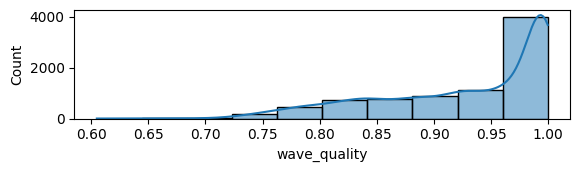

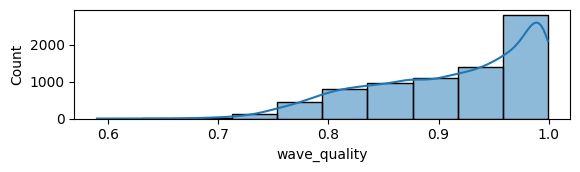

<Axes: xlabel='wave_quality', ylabel='Count'>

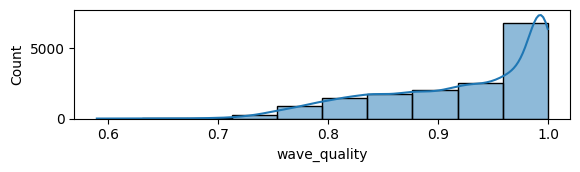

In [66]:
from matplotlib import figure

plt.subplot(3, 1, 1)  # 1行2列，第1个子图
sns.histplot(train_pos_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 2)  # 1行2列，第1个子图
sns.histplot(train_neg_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 3)  # 1行2列，第1个子图
sns.histplot(train_combined['wave_quality'], kde=True, bins=10)

In [67]:
wave_quality_threshold = 0.9

In [68]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (8157, 40)
train neg sample shape: (7694, 40)
test pos sample shape: (67, 40)
test neg sample shape: (63, 40)


In [69]:
train_pos_dataset_final_filter = train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold]
train_neg_dataset_final_filter = train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold]

print(f"After quality filter, train positive sample count: {train_pos_dataset_final_filter.shape[0]}")
print(f"After quality filter, train negative sample count: {train_neg_dataset_final_filter.shape[0]}")


After quality filter, train positive sample count: 5560
After quality filter, train negative sample count: 4715


In [70]:
sample_folder = os.path.join(os.getcwd(), 'samples')
os.makedirs(sample_folder, exist_ok=True)

# 定义要保存的文件路径
train_pos_path = os.path.join(sample_folder, 'train_pos_dataset.pkl')
train_neg_path = os.path.join(sample_folder, 'train_neg_dataset.pkl')
test_pos_path = os.path.join(sample_folder, 'test_pos_dataset.pkl')
test_neg_path = os.path.join(sample_folder, 'test_neg_dataset.pkl')

# 保存 DataFrame 为 .pkl 文件
train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_pos_path)
train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_neg_path)
test_pos_dataset_final[test_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(test_pos_path)
test_neg_dataset_final[test_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(test_neg_path)

In [71]:
print(train_pos_dataset_final.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_HFn', 'HRV_LnHF', 'wave_quality', 'label', 'id', 'age',
       'gender'],
      dtype='object')
